In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform
# Standard linear model
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize



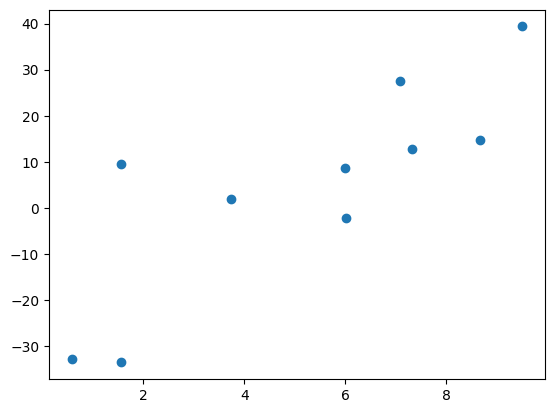

In [3]:
# Bayesian Regression
np.random.seed(42)
x = np.random.uniform(0, 10, 10)
y = 3 * x + np.random.normal(0, 20, 10)

test = np.random.uniform(0, 5, 1000)
min_val = float('inf')
min_index = None
for i in range(len(test)):
    pred = test[i] * x
    error = y - pred
    if np.sum(error) < min_val:
        min_val = np.sum(error)
        min_index = i

# Plot the data points
plt.scatter(x, y)
plt.show()

In [4]:


lm = LinearRegression(fit_intercept=False)
lm.fit(x.reshape(-1, 1), y)
print("Coefficients:")
print(lm.coef_)

Coefficients:
[2.16061302]


In [5]:
# Maximum Likelihood Estimate
def likelihood(beta, sd):
    y_pred = beta * x
    res = y - y_pred
    l = norm.logpdf(res, loc=0, scale=sd).sum()
    return l


def ml_likelihood(params):
    beta = params[0]
    sd = params[1]
    if sd <= 0:
        return -np.inf
    y_pred = beta * x
    res = y - y_pred
    l = norm.logpdf(res, loc=0, scale=sd).sum()
    return -l

In [6]:


result = minimize(ml_likelihood, [1, 1], method="Nelder-Mead")
print("Maximum Likelihood Estimates:")
print(result.x)

Maximum Likelihood Estimates:
[ 2.16060404 18.38148503]


In [7]:
# Bayesian Regression
def posterior_estimate(beta, sd, prior_beta, prior_sd):
    l = likelihood(beta, sd) + prior_beta, prior_sd
    return l

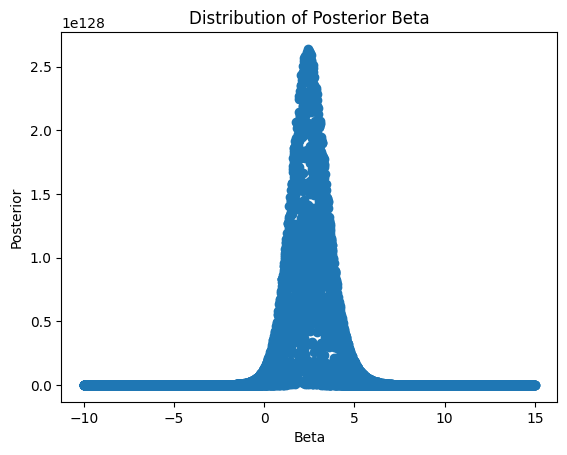

In [22]:
# Brute force result

# Set a strong prior of beta = 3 with a standard deviation = 0.1
betas = np.random.uniform(-10, 15, 10000)
beta_p = norm.logpdf(betas, loc=5, scale=3)

# SDs prior
sds = np.random.uniform(10, 30, 10000)
sds_p = uniform.logpdf(sds, loc=10, scale=20)

parameters = np.column_stack((betas, sds, beta_p, sds_p))
parameters = np.hstack((parameters, np.zeros((parameters.shape[0], 1))))

for i in range(parameters.shape[0]):
    parameters[i, -1] = posterior_estimate(parameters[i, 0], parameters[i, 1], parameters[i, 2], parameters[i, 3])

parameters[:, -1] = np.exp(parameters[:, -1] - np.min(parameters[:, -1])) / (np.max(parameters[:, -1]) - np.min(parameters[:, -1]))

plt.scatter(parameters[:, 0], parameters[:, -1])
plt.title("Distribution of Posterior Beta")
plt.xlabel("Beta")
plt.ylabel("Posterior")
plt.show()

In [23]:
# Set up parameters
iterations = 20000
burnin = 2000

# Define support functions
def jump_function(x_in):
    b_proposal = np.random.normal(x_in[0], 1)
    sd_proposal = np.random.uniform(x_in[1] - 0.5, x_in[1] + 0.5)
    if b_proposal < 0:
        b_proposal = 0.01
    if sd_proposal < 15:
        sd_proposal = 15
    return {"b_proposal": b_proposal, "sd_proposal": sd_proposal}

def prior_likelihood(params):
    return np.log(norm.pdf(params[0], 5, 3)) + np.log(norm.pdf(params[1], 10, 30))

def posterior_mh(beta, sd):
    return likelihood(beta, sd) + prior_likelihood([beta, sd])



In [24]:
# Set up the parameter matrix
parameters = np.empty((iterations, 5))
parameters[:, :] = np.nan
parameters[0, :] = [betas[0], sds[0], beta_p[0], sds_p[0], np.nan]

# Run the Metropolis-Hastings algorithm
for i in range(iterations-1):
    # Calculate the posterior for the current iteration
    parameters[i, 4] = posterior_mh(parameters[i, 0], parameters[i, 1])
  
    # Find a proposal point
    proposals = jump_function(parameters[i, :2])
  
    # Calculate the posterior for the proposal
    proposal_likelihood = posterior_mh(proposals['b_proposal'], proposals['sd_proposal'])
  
    acceptance_ratio = np.exp(proposal_likelihood - parameters[i, 4])
  
    # If the proposal likelihood is greater, always accept the proposal
    if acceptance_ratio > 1:
        parameters[i+1, :2] = proposals['b_proposal'], proposals['sd_proposal']
    else:
        # Otherwise, sometimes accept and sometimes explore
        p = np.random.uniform(0, 1)
        if p > (1 - acceptance_ratio):
            parameters[i+1, :2] = proposals['b_proposal'], proposals['sd_proposal']
        else:
            parameters[i+1, :2] = parameters[i, :2]



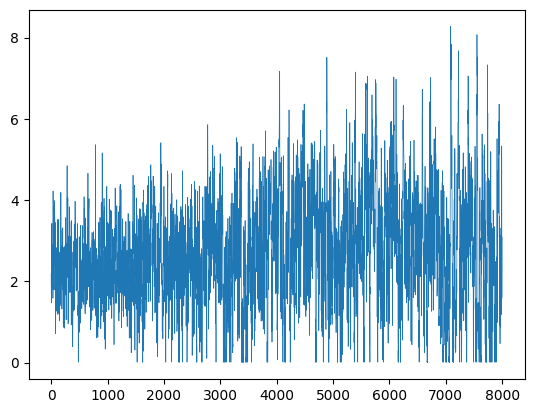

In [18]:
# Plot the "chain"
plt.plot(parameters[burnin:iterations, 0], linewidth=0.5)

(array([308., 146., 181., 248., 356., 455., 551., 605., 654., 760., 607.,
        485., 542., 460., 387., 330., 253., 177., 150., 110.,  65.,  51.,
         31.,  23.,  11.,  29.,  10.,  10.,   1.,   4.]),
 array([9.43736377e-04, 2.76765034e-01, 5.52586331e-01, 8.28407628e-01,
        1.10422893e+00, 1.38005022e+00, 1.65587152e+00, 1.93169282e+00,
        2.20751411e+00, 2.48333541e+00, 2.75915671e+00, 3.03497801e+00,
        3.31079930e+00, 3.58662060e+00, 3.86244190e+00, 4.13826320e+00,
        4.41408449e+00, 4.68990579e+00, 4.96572709e+00, 5.24154838e+00,
        5.51736968e+00, 5.79319098e+00, 6.06901228e+00, 6.34483357e+00,
        6.62065487e+00, 6.89647617e+00, 7.17229747e+00, 7.44811876e+00,
        7.72394006e+00, 7.99976136e+00, 8.27558265e+00]),
 <BarContainer object of 30 artists>)

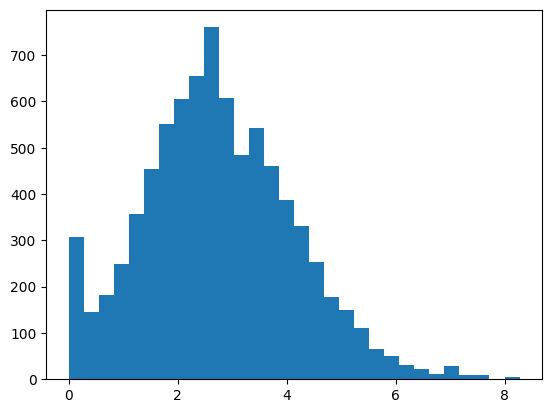

In [19]:
# Plot a histogram of the Beta posterior
plt.hist(parameters[burnin:iterations, 0], bins=30)

In [20]:
# Calculate and print the mean of the Beta posterior
print(np.mean(parameters[burnin:iterations, 0]))

2.753301936264206
